In [264]:
import json, time, re, requests, pickle
import pandas as pd
import psycopg2 as pg2
import numpy as np
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from psycopg2.extras import RealDictCursor, Json
from psycopg2.extensions import AsIs

%matplotlib inline
plt.style.use('fivethirtyeight')

%run ../assets/sql_cred.py

In [2]:
def filename_format_log(file_path, 
                        logfile = '../assets/file_log.txt', 
                        now = round(time.time()), 
                        file_description = None): 
   
    try:
        ext = re.search('(?<!^)(?<!\.)\.(?!\.)', file_path).start() 
    except:
        raise NameError('Please enter a relative path with a file extension.') 
    
    stamp = re.search('(?<!^)(?<!\.)[A-z]+_[0-z]+(?=\.)', file_path).start()
    formatted_name = f'{file_path[:stamp]}{now}_{file_path[stamp:]}'  
    if not file_description:
        file_description = f'Saved at: {time.asctime(time.gmtime(now))}'
    with open(logfile, 'a+') as f:
        f.write(f'{formatted_name}: {file_description}\n')
    return formatted_name, now, file_description

In [3]:
engine = create_engine(ENGINE)

In [4]:
def con_cur_to_db(dbname=DBNAME, dict_cur=None):
    con = pg2.connect(host=IP_ADDRESS,
                  dbname=dbname,
                  user=USER,
                  password=PASSWORD)
    if dict_cur:
        cur = con.cursor(cursor_factory=RealDictCursor)
    else:
        cur = con.cursor()
    return con, cur
    
def execute_query(query, dbname=DBNAME, dict_cur=None, command=False):
    con, cur = con_cur_to_db(dbname, dict_cur)
    cur.execute(f'{query}')
    if not command:
        data = cur.fetchall()
        con.close()
        return data
    con.commit() #sends to server
    con.close() #closes server connection

In [5]:
query = '''SELECT * FROM track_list;'''
response = execute_query(query, dict_cur=True)
track_df = pd.DataFrame(response)
track_df.set_index('track_id', inplace=True)
track_df.head()

,album_name,artist_name,lyrics,playlist_id,playlist_name,playlist_owner,track_name
track_id,,,,,,,
0h7TlF8gKb61aSm874s3cV,I Can't Tell You How Much It Hurts,moow,\n\nIf your needle is near\nNeedle is near\nYo...,37i9dQZF1DXarebqD2nAVg,Tender,spotify,You'r in My Head
6koowTu9pFHPEcZnACLKbK,Coming Home,Leon Bridges,\n\n[Verse 1]\nBrown skin girl on the other si...,37i9dQZF1DX4adj7PFEBwf,Wedding Bells,spotify,Brown Skin Girl
1JkhKUXAoNivi87ipmV3rp,Back To Love (Deluxe Version),Anthony Hamilton,"\n\n[Verse 1]\nIt's simple, I love it\nHaving ...",37i9dQZF1DX4adj7PFEBwf,Wedding Bells,spotify,Best of Me
51lPx6ZCSalL2kvSrDUyJc,The Search for Everything,John Mayer,\n\n[Intro: Whistling]\n\n[Verse 1]\nA great b...,37i9dQZF1DX4adj7PFEBwf,Wedding Bells,spotify,You're Gonna Live Forever in Me
3vqlZUIT3rEmLaYKDBfb4Q,Songs In The Key Of Life,Stevie Wonder,\n\n[Verse 1]\nIsn't she lovely\nIsn't she won...,37i9dQZF1DX4adj7PFEBwf,Wedding Bells,spotify,Isn't She Lovely


In [6]:
lyric_df = track_df[['lyrics']]

In [7]:
lyric_df = lyric_df.dropna(axis=0)

In [8]:
lyric_df.shape

(2276, 1)

In [9]:
lyric_df.head()

,lyrics
track_id,
0h7TlF8gKb61aSm874s3cV,\n\nIf your needle is near\nNeedle is near\nYo...
6koowTu9pFHPEcZnACLKbK,\n\n[Verse 1]\nBrown skin girl on the other si...
1JkhKUXAoNivi87ipmV3rp,"\n\n[Verse 1]\nIt's simple, I love it\nHaving ..."
51lPx6ZCSalL2kvSrDUyJc,\n\n[Intro: Whistling]\n\n[Verse 1]\nA great b...
3vqlZUIT3rEmLaYKDBfb4Q,\n\n[Verse 1]\nIsn't she lovely\nIsn't she won...


In [10]:
def clean_lyrics(lyrics, keep_tags=False, keep_nl=False):

    text = lyrics.lower()

    if not keep_tags:
        text = re.sub('(\[.+\])', '', text)

    text = re.sub('[^a-z\s]', '', text)

    text = text.strip()
    text = re.sub('\n\n', ' ', text) 

    text = text.strip()

    if keep_nl:
        text = re.sub('\n', ' \n ', text)
    else:
        text = re.sub('\n', ' ', text)


    return text

In [11]:
lyric_df['clean_lyrics'] = lyric_df.lyrics.map(lambda x: clean_lyrics(x, keep_tags=False, keep_nl=True))

In [12]:
lyric_df.head()

,lyrics,clean_lyrics
track_id,,
0h7TlF8gKb61aSm874s3cV,\n\nIf your needle is near\nNeedle is near\nYo...,if your needle is near \n needle is near \n yo...
6koowTu9pFHPEcZnACLKbK,\n\n[Verse 1]\nBrown skin girl on the other si...,brown skin girl on the other side of the room ...
1JkhKUXAoNivi87ipmV3rp,"\n\n[Verse 1]\nIt's simple, I love it\nHaving ...",its simple i love it \n having you near me hav...
51lPx6ZCSalL2kvSrDUyJc,\n\n[Intro: Whistling]\n\n[Verse 1]\nA great b...,a great big bang and dinosaurs \n fiery rainin...
3vqlZUIT3rEmLaYKDBfb4Q,\n\n[Verse 1]\nIsn't she lovely\nIsn't she won...,isnt she lovely \n isnt she wonderful \n isnt ...


In [13]:
not_eng = lyric_df[lyric_df['clean_lyrics'].str.contains('(\sdel\s)|(\sque\s)|(\svous\s)|(\setre\s)')].index.tolist()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



In [14]:
lyric_df = lyric_df.drop(index=not_eng, axis=0)

In [15]:
not_lyrics = lyric_df[lyric_df['clean_lyrics'].str.contains('lyrics for this song have yet')].index.tolist()

In [16]:
lyric_df = lyric_df.drop(index=not_lyrics, axis=0)

In [207]:
lyric_df.loc['1Ob94QesoxHSBrypyBbdfd'].lyrics = "\n\n[Verse 1]\nWe've been here before, surrounded in the cold\nYou take me to places I've never known\nAnd you push me to places I'll never go\nI would die for you\nTell me the truth\nAm I all that you would need?\nIf we're keeping it a hundred, you're all that I need for me\nFrom the jump until forever from now, I would ride for you\n\n[Chorus]\nBut you got me shot down by love\nYou got my heart now\nWhy won't you stop now?\nOh I've been knocked down by you\nYou got my heart now\nWhy won't you stop now?\n\n[Verse 2]\nI've been through it whole\nI've been through the worst\nBut I never knew how much our love could hurt\nOver my family I put you first\nWriting out my feelings is the only thing that work\nI don't hear from the friends I thought were mine too\nBut I hold on to the poems I would write you\nHappy seventeen, I saw us two and you saw three\nI guess our lines are structured like a haiku\n\n[Chorus 2]\nYou got me shot down by love\nAnd you got my heart now\nWhy won't you stop now?\nOh I've been knocked down by you\nAnd you got my heart now\nWhy won't you stop now?\n\n[Bridge]\nKnocked down, knocked down\nKnocked down, knocked down\nKnocked down\nKnocked down\n\n[Chorus]\nI've been shot down by love\nYou got my heart now\nWhy won't you stop now?\nI've been knocked down by you\nAnd you got my heart now\nWhy won't you stop now?\n\n"

In [17]:
long_gap = lyric_df[lyric_df['clean_lyrics'].str.contains(r'(\s{6,})')].index.tolist()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



In [18]:
lyric_df = lyric_df.drop(index=long_gap, axis=0)

In [19]:
lyric_df = lyric_df.drop_duplicates(subset=['clean_lyrics'])

In [105]:
lyric_df = lyric_df.drop(index='1mjWhM7GQTTxJxg2F0iCRS', axis=0)

In [139]:
lyric_df = lyric_df.drop(index='4tjLYTXFqZhkUDga4bQ0yl', axis=0)

In [145]:
lyric_df.describe()

,total_words_track,unique_words_track,total_lines_track,unique_lines_track,mean_words_line,mean_unique_words_line
count,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000
mean,284.514286,96.840896,40.661064,27.560224,11.542241,8.510756
std,136.291119,44.114334,18.013478,12.201590,62.028609,24.885099
min,13.000000,5.000000,1.000000,1.000000,4.200000,3.600000
25%,195.000000,74.000000,28.000000,20.000000,7.900000,6.600000
50%,267.000000,92.000000,38.000000,25.000000,8.800000,7.400000
75%,346.000000,112.000000,51.000000,33.000000,9.900000,8.300000
max,2230.000000,956.000000,224.000000,189.000000,2230.000000,956.000000


In [146]:
corpus = []
words_track = []    
lines_track = []

for _, track in lyric_df[['clean_lyrics']].iterrows():
    #words in full set
    lyrics = track[0]
    lyrics_spaced = re.sub(r'( +)', ' ', lyrics)
    lyrics_split = lyrics_spaced.split(' ')
    corpus.extend(lyrics_split)
    
    #lines in track
    lines_split = lyrics_spaced.split('\n')
    lines_track.append(lines_split)
    
    #words in track w/o \n 
    lyrics_spaced = re.sub(r'\n ', '', lyrics_spaced)
    lyrics_split = lyrics_spaced.split(' ')
    words_track.append(lyrics_split)

In [147]:
vocab = set(list(corpus))

In [148]:
len(vocab)

12976

In [149]:
count_words_track = []
for i in words_track:
    count_words_track.append(len(i))

In [150]:
lyric_df['total_words_track'] = count_words_track

In [151]:
unique_words_track = []
for track in words_track:
    unique_words_track.append(set(track))

In [152]:
count_unique_words_track = []
for track in unique_words_track:
    count_unique_words_track.append(len(track))

In [153]:
lyric_df['unique_words_track'] = count_unique_words_track

In [154]:
np.mean(count_words_track)

284.51428571428573

In [155]:
len_words_track = []
for i in words_track:
    len_words = []
    for word in i:
        len_words.append(len(word))
    len_words_track.append(np.around(np.mean(len_words),1))

In [156]:
count_lines_track = []
for i in lines_track:
    count_lines_track.append(len(i))

In [157]:
lyric_df['total_lines_track'] = count_lines_track

In [158]:
unique_lines_track = []
for track in lines_track:
    unique_lines_track.append(set(track))

In [159]:
count_unique_lines_track = []
for track in unique_lines_track:
    count_unique_lines_track.append(len(track))

In [160]:
lyric_df['unique_lines_track'] = count_unique_lines_track

In [161]:
lyric_df.head()

,lyrics,clean_lyrics,total_words_track,unique_words_track,total_lines_track,unique_lines_track,mean_words_line,mean_unique_words_line
track_id,,,,,,,,
0h7TlF8gKb61aSm874s3cV,\n\nIf your needle is near\nNeedle is near\nYo...,if your needle is near \n needle is near \n yo...,57,20,14,8,5.9,5.1
6koowTu9pFHPEcZnACLKbK,\n\n[Verse 1]\nBrown skin girl on the other si...,brown skin girl on the other side of the room ...,132,52,24,13,7.4,5.8
1JkhKUXAoNivi87ipmV3rp,"\n\n[Verse 1]\nIt's simple, I love it\nHaving ...",its simple i love it \n having you near me hav...,151,63,29,21,7.1,5.8
51lPx6ZCSalL2kvSrDUyJc,\n\n[Intro: Whistling]\n\n[Verse 1]\nA great b...,a great big bang and dinosaurs \n fiery rainin...,126,76,20,18,8.2,7.2
3vqlZUIT3rEmLaYKDBfb4Q,\n\n[Verse 1]\nIsn't she lovely\nIsn't she won...,isnt she lovely \n isnt she wonderful \n isnt ...,108,66,21,20,7.0,6.1


In [162]:
np.mean(count_lines_track)

40.661064425770306

In [163]:
len_word = 0
for word in vocab:
    len_word += len(word)

In [164]:
mean_len_word = len_word / len(vocab)
mean_len_word

6.466784833538841

In [165]:
mean_words_line = []
for track in lines_track:
    words_line = []
    for line in track:
        words_line.append(len(line.split(' ')))
    mean_words_line.append(np.around(np.mean(words_line),1))

In [166]:
lyric_df['mean_words_line'] = mean_words_line

In [167]:
mean_unique_words_line = []
for track in lines_track:
    unique_words_line = []
    for line in track:
        unique_words_line.append(len(set(line.split(' '))))
    mean_unique_words_line.append(np.around(np.mean(unique_words_line),1))

In [168]:
lyric_df['mean_unique_words_line'] = mean_unique_words_line

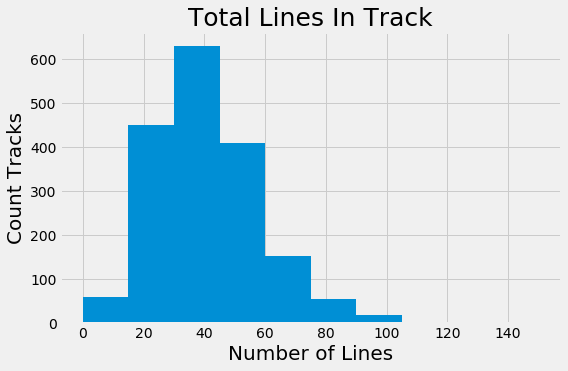

In [265]:
plt.figure(figsize=(8,5));
plt.title('Total Lines In Track', fontsize=25);
plt.xlabel('Number of Lines', fontsize=20);
plt.ylabel('Count Tracks', fontsize=20);
plt.hist(lyric_df['total_lines_track'], range=(0,150));

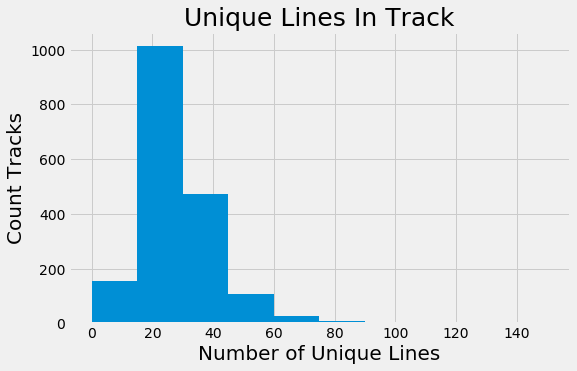

In [266]:
plt.figure(figsize=(8,5));
plt.title('Unique Lines In Track', fontsize=25);
plt.xlabel('Number of Unique Lines', fontsize=20);
plt.ylabel('Count Tracks', fontsize=20);
plt.hist(lyric_df['unique_lines_track'], range=(0,150));

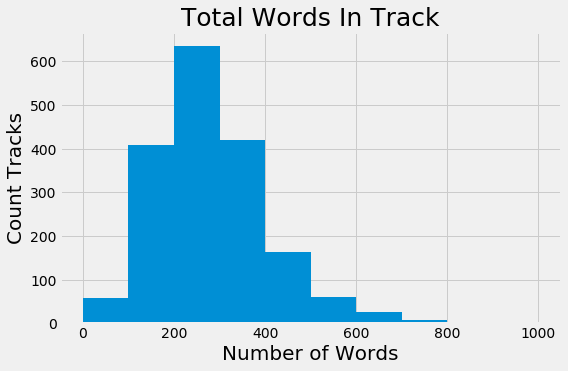

In [267]:
plt.figure(figsize=(8,5));
plt.title('Total Words In Track', fontsize=25);
plt.xlabel('Number of Words', fontsize=20);
plt.ylabel('Count Tracks', fontsize=20);
plt.hist(lyric_df['total_words_track'], range=(0, 1000));

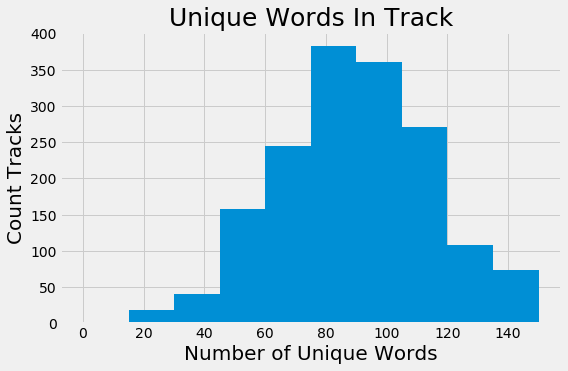

In [268]:
plt.figure(figsize=(8,5));
plt.title('Unique Words In Track', fontsize=25);
plt.xlabel('Number of Unique Words', fontsize=20);
plt.ylabel('Count Tracks', fontsize=20);
plt.hist(lyric_df['unique_words_track'], range=(0,150));

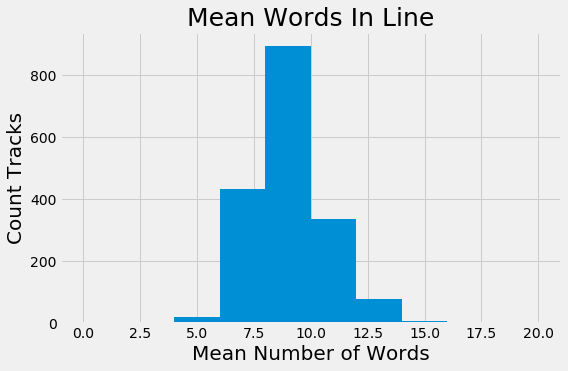

In [269]:
plt.figure(figsize=(8,5));
plt.title('Mean Words In Line', fontsize=25);
plt.xlabel('Mean Number of Words', fontsize=20);
plt.ylabel('Count Tracks', fontsize=20);
plt.hist(lyric_df['mean_words_line'], range=(0,20));

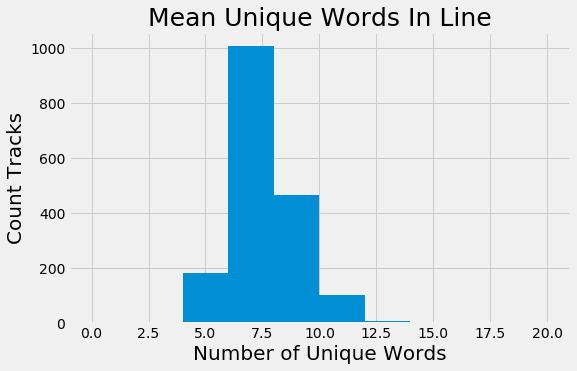

In [270]:
plt.figure(figsize=(8,5));
plt.title('Mean Unique Words In Line', fontsize=25);
plt.xlabel('Number of Unique Words', fontsize=20);
plt.ylabel('Count Tracks', fontsize=20);
plt.hist(lyric_df['mean_unique_words_line'], range=(0,20));

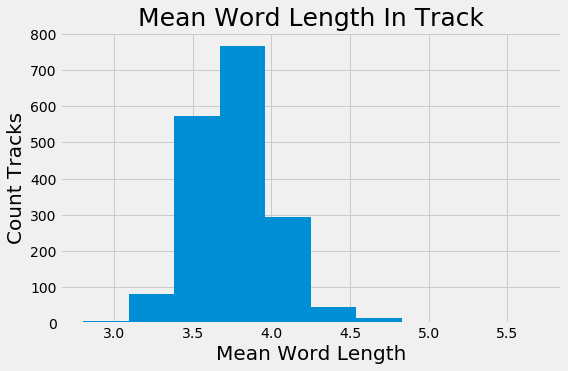

In [271]:
plt.figure(figsize=(8,5));
plt.title('Mean Word Length In Track', fontsize=25);
plt.xlabel('Mean Word Length', fontsize=20);
plt.ylabel('Count Tracks', fontsize=20);
plt.hist(len_words_track);

In [176]:
lyric_df.describe()

,total_words_track,unique_words_track,total_lines_track,unique_lines_track,mean_words_line,mean_unique_words_line
count,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000
mean,284.514286,96.840896,40.661064,27.560224,11.542241,8.510756
std,136.291119,44.114334,18.013478,12.201590,62.028609,24.885099
min,13.000000,5.000000,1.000000,1.000000,4.200000,3.600000
25%,195.000000,74.000000,28.000000,20.000000,7.900000,6.600000
50%,267.000000,92.000000,38.000000,25.000000,8.800000,7.400000
75%,346.000000,112.000000,51.000000,33.000000,9.900000,8.300000
max,2230.000000,956.000000,224.000000,189.000000,2230.000000,956.000000


In [177]:
lyric_df[lyric_df.loc[:,'total_words_track'] < 10]

,lyrics,clean_lyrics,total_words_track,unique_words_track,total_lines_track,unique_lines_track,mean_words_line,mean_unique_words_line
track_id,,,,,,,,


In [178]:
trace = go.histogram(x=words_line)
data = trace
py.iplot([trace])

TypeError: 'module' object is not callable

In [179]:
# formatted_name, now, file_description= filename_format_log(file_path = '../assets/lyric_df.csv')

# lyric_df.to_csv(formatted_name, index=False)

In [208]:
eda_df = pd.DataFrame(columns=['id', 'line', 'line_num', 'tag'])

for idx, track in lyric_df[['lyrics']].iterrows():
    track = re.sub('(\[[^\]]+\]\\n\\n)', '', track[0]) #removes tags without lyrics
    track = re.sub('\[[^\[]+(:[^\]]+)\]', '', track) #removes all text after :
    track = re.sub('\[[^\[]+(–[^\]]+)|\[[^\[]+(-\s[^\]]+)\]', '', track) #removes all after –
    track = re.sub('\[[^\[]+(\(([^\]]+))\]', '', track) #removes all after ()
    track = re.sub('(^|)(\[Ad-Libs\])|(\[Keisha\])|(\[Shane Powers\])', '', track) #removes artist and non-standard tags
    track = re.sub('(^|)(\[Break\])|(\[Vocals / Lyrics By\])|(\[Skit\])', '', track) #removes artist and non-standard tags
    
    tags = re.findall('(\[[^\]]+\])', track) #finds all tags
    track = re.sub('(\[[^\]]+\])', '', track) #removes all tags
              
    track = track.strip().split('\n\n') 
    track_split = [verse.strip().split('\n') for verse in track] 
    
    v_count = len(track_split)

    for i in range(v_count):
        if len(tags) == v_count:
            tag = tags[i]
        else:
            tag = f'[verse {(i+1)}]'
        
        for j, line in enumerate(track_split[i]):
            index = 1
            
            row = {
            'id': idx,
            'line':line,
            'line_num':(j+1),
            'tag': tag.lower()
            }
            
            eda_df = eda_df.append(row, ignore_index=True)

In [212]:
eda_df

,id,line,line_num,tag
0,0h7TlF8gKb61aSm874s3cV,If your needle is near,1,[verse 1]
1,0h7TlF8gKb61aSm874s3cV,Needle is near,2,[verse 1]
2,0h7TlF8gKb61aSm874s3cV,You can take my blood,3,[verse 1]
3,0h7TlF8gKb61aSm874s3cV,Oh I saved it for you,4,[verse 1]
4,0h7TlF8gKb61aSm874s3cV,Hundreds of drops,5,[verse 1]
5,0h7TlF8gKb61aSm874s3cV,Running red,6,[verse 1]
6,0h7TlF8gKb61aSm874s3cV,Needle is near,1,[verse 2]
7,0h7TlF8gKb61aSm874s3cV,You can take my blood,2,[verse 2]
8,0h7TlF8gKb61aSm874s3cV,Oh I saved it for you,3,[verse 2]
9,0h7TlF8gKb61aSm874s3cV,Hundreds of drops,4,[verse 2]


In [213]:
# formatted_name, now, file_description = filename_format_log(file_path ='../assets/eda_df.csv')
# eda_df.to_csv(formatted_name, index=False)

In [214]:
# eda_df = pd.read_csv('../assets/1548892595_eda_df.csv')

In [240]:
eda_df.tag.value_counts()[eda_df.tag.value_counts() < 10]

[jazz]                        9
[verse  4]                    9
[rod stewart]                 9
[chorus/outro]                9
[mike]                        8
[coko]                        8
[brian morgan]                8
[pre-chorus 3]                8
[verse 23]                    8
[sisqo]                       8
[hook 1]                      7
[verse  2]                    7
[chorus 3/outro]              7
[verse 2 / outro]             7
[verso 3]                     6
[vesre 1]                     6
[verso 2]                     6
[alt. chorus]                 5
[verse 24]                    5
[carols]                      5
[​chorus]                     5
[verso 1]                     5
[verse 5/bridge]              5
[chorus / outro]              5
[instrumental break]          5
[sting]                       4
[refrain 3]                   4
[rod stewart, bryan adams]    4
[bryan adams]                 4
[tag]                         4
[instrumental]                4
[pre-chr

In [241]:
drop = eda_df[eda_df['id'] == '4TYZXfu6VeblQMK2TwbDte'].index.tolist()

In [242]:
eda_df = eda_df.drop(drop, axis=0)

In [243]:
eda_df[eda_df.loc[:,'tag'] == '[verse 55]']

,id,line,line_num,tag


In [244]:
lyric_df.loc['6xYd4zCVeSp80Un2Rl9wDs',:]['lyrics']

"\n\nBaby let's cruise away from here\n\nDon't be confused baby, the way is clear\n\nAnd if you want it you got it forever\n\nOh, this is not a one night stand baby\n\nLet the music take your mind\n\nAnd just release and you will find, baby\n\nWe're going to fly away\n\nGlad you're going my way\n\nI love it when we're cruisin' together\n\nMusic was made for love\n\nCruisin' is made for love\n\nI love it when we're cruisin' together\n\nBaby, tonight belongs to us\n\nEverything's right, do what you must, baby\n\nAnd inch by inch we get closer and closer\n\nEvery little part of each other ooh, baby, baby\n\nLet the music take your mind\n\nJust release and you will find, baby\n\nWe're going to fly away\n\nGlad you're going my way\n\nI love it when we're cruisin' together\n\nMusic was made for love\n\nCruisin' is made for love\n\nI love you when we're cruisin' together\n\nWe're going to fly away\n\nGlad you're going my way\n\nI love it when we're cruisin' together\n\nMusic was made for love

In [245]:
off_verse = eda_df[eda_df.id =='6xYd4zCVeSp80Un2Rl9wDs'].index.tolist()

In [246]:
eda_df.tag.loc[off_verse] = eda_df.tag.loc[off_verse].map(lambda x: '[verse 1]')

In [247]:
eda_df.loc[off_verse,'line_num'] = list(range(1,63))

In [248]:
eda_df.tag.value_counts()

[verse 1]                     11016
[verse 2]                      9690
[chorus]                       7979
[verse 3]                      7625
[verse 4]                      6456
[verse 5]                      5855
[verse 6]                      4778
[verse 7]                      3622
[verse 8]                      2519
[verse 9]                      1637
[bridge]                       1507
[pre-chorus]                   1157
[outro]                        1149
[verse 10]                      968
[verse 11]                      647
[hook]                          424
[verse 12]                      371
[chorus 2]                      339
[post-chorus]                   265
[verse]                         260
[chorus 1]                      254
[verse 13]                      206
[verse 14]                      168
[verse 15]                      135
[intro]                         127
[pre-chorus 2]                  104
[verse 16]                       94
[pre-chorus 1]              

In [249]:
eda_df[eda_df.tag.str.contains('\n')]

,id,line,line_num,tag


In [250]:
eda_df[eda_df.loc[:,'tag'] == '[verse 28]']

,id,line,line_num,tag


In [251]:
leagues = eda_df[eda_df.id =='2za6PlkAQAMMu0VFsfBoHC'].index.tolist()

In [252]:
eda_df = eda_df.drop(index=leagues, axis=0)

In [253]:
eda_df.describe()

,id,line,line_num,tag
count,70327,70327,70327,70327
unique,1783,45128,62,98
top,1ZzbD3g1K6LY2S1w5cdowm,Yeah,1,[verse 1]
freq,241,41,12485,11016


In [254]:
eda_df[eda_df.id == '1ZzbD3g1K6LY2S1w5cdowm']

,id,line,line_num,tag
1047,1ZzbD3g1K6LY2S1w5cdowm,Woke up in the mornin,1,[verse 1]
1048,1ZzbD3g1K6LY2S1w5cdowm,With ya on my mind,2,[verse 1]
1049,1ZzbD3g1K6LY2S1w5cdowm,Visualize old times,3,[verse 1]
1050,1ZzbD3g1K6LY2S1w5cdowm,Let's bring it back,4,[verse 1]
1051,1ZzbD3g1K6LY2S1w5cdowm,Dial one time,5,[verse 1]
1052,1ZzbD3g1K6LY2S1w5cdowm,And ya hit me back,6,[verse 1]
1053,1ZzbD3g1K6LY2S1w5cdowm,Think it's 'bout time,7,[verse 1]
1054,1ZzbD3g1K6LY2S1w5cdowm,That I needed that,8,[verse 1]
1055,1ZzbD3g1K6LY2S1w5cdowm,Little bit a,9,[verse 1]
1056,1ZzbD3g1K6LY2S1w5cdowm,Heaven sent her,10,[verse 1]


In [255]:
eda_df[eda_df.id == '3yPMLvxeEor7rbDLDseJFt']

,id,line,line_num,tag


In [256]:
tracks = eda_df[eda_df.id == '3yPMLvxeEor7rbDLDseJFt'].index.tolist()

In [257]:
eda_df = eda_df.drop(index=tracks, axis=0)

In [258]:
eda_df.describe()

,id,line,line_num,tag
count,70327,70327,70327,70327
unique,1783,45128,62,98
top,1ZzbD3g1K6LY2S1w5cdowm,Yeah,1,[verse 1]
freq,241,41,12485,11016


In [259]:
eda_df.tag.value_counts()

[verse 1]                     11016
[verse 2]                      9690
[chorus]                       7979
[verse 3]                      7625
[verse 4]                      6456
[verse 5]                      5855
[verse 6]                      4778
[verse 7]                      3622
[verse 8]                      2519
[verse 9]                      1637
[bridge]                       1507
[pre-chorus]                   1157
[outro]                        1149
[verse 10]                      968
[verse 11]                      647
[hook]                          424
[verse 12]                      371
[chorus 2]                      339
[post-chorus]                   265
[verse]                         260
[chorus 1]                      254
[verse 13]                      206
[verse 14]                      168
[verse 15]                      135
[intro]                         127
[pre-chorus 2]                  104
[verse 16]                       94
[pre-chorus 1]              

In [260]:
bad_tag = eda_df.tag[eda_df.tag.str.contains('\n')].index.tolist()

In [261]:
eda_df = eda_df.drop(index=bad_tag,axis=0)

In [262]:
eda_df.tag.value_counts()

[verse 1]                     11016
[verse 2]                      9690
[chorus]                       7979
[verse 3]                      7625
[verse 4]                      6456
[verse 5]                      5855
[verse 6]                      4778
[verse 7]                      3622
[verse 8]                      2519
[verse 9]                      1637
[bridge]                       1507
[pre-chorus]                   1157
[outro]                        1149
[verse 10]                      968
[verse 11]                      647
[hook]                          424
[verse 12]                      371
[chorus 2]                      339
[post-chorus]                   265
[verse]                         260
[chorus 1]                      254
[verse 13]                      206
[verse 14]                      168
[verse 15]                      135
[intro]                         127
[pre-chorus 2]                  104
[verse 16]                       94
[pre-chorus 1]              

In [239]:
trace = go.histogarm(x=eda_df.tag)
data = trace
py.iplot([trace])

AttributeError: module 'plotly.graph_objs' has no attribute 'histogarm'